#### This program computes the linear regression coefficients and intercept to predict the Zn Drop in  106TK01 from the following features:
1. dezn flow
2. dezn feed temp
3. 105tk05 temp
4. H2S flow to dezn
5. ntrl pls condition
6. 105TK03 AAS Zn
7. 105TK05 pls analysis
(Ridge regression) Tensorflow is used.


This is a continuation from the ZnNi_Proj_Load_Data_Gathered_2015_to_2020Aug.ipynb file

In [51]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.parser import parse
from itertools import compress
from collections import OrderedDict
from datetime import date
import datetime
from datetime import timedelta
import re

import openpyxl
import random

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [52]:
#-------Load the DF_combined data from ZnDrop_Proj_Load_Data_Gathered_2017_to_2020Aug.ipynb file

# ZnNi_project_NTRL_TK03_TK05_MSTK01_intrpltd_2015_2020_PIdata_DF.xlsx ---> previous version dataset
# The ZnNi_project_NTRL_TK03_TK05_MSTK01_intrpltdLINEAR_2015_2020_PIdata_DF.xlsx dataset is already ret time adjusted for 105 and 106 samples

DF_NTRL_TK03_TK05_MSTK01 = pd.read_excel(r'C:\Users\v.t.flores\Documents\ZnNi_project_NTRL_TK03_TK05_MSTK01_intrpltdLINEAR_2015_2020_PIdata_DF.xlsx')
DF_NTRL_TK03_TK05_MSTK01_1 = DF_NTRL_TK03_TK05_MSTK01.set_index('DATETIME')

#convert the df to numeric
for i in DF_NTRL_TK03_TK05_MSTK01_1.columns:
    DF_NTRL_TK03_TK05_MSTK01_1[i] = pd.to_numeric(DF_NTRL_TK03_TK05_MSTK01_1[i], errors='coerce')
    


In [53]:
# If predicting ZnDrop,  Drop the 106_Zn, 106_Ni and tk03_zn columns
#DF_main_20152020 = DF_NTRL_TK03_TK05_MSTK01_1.drop(['106_Zn', '106_Ni', 'tk03_Zn'], axis=1)
#DF_MAIN_2015_2020 = DF_main_20152020.dropna()

# If predicting 106_Zn, Drop the 106_Ni , Zn_Drop and tk03_zn columns
DF_main_20152020 = DF_NTRL_TK03_TK05_MSTK01_1.drop(['Zn_Drop', '106_Ni', 'tk03_Zn', '106_Zn'], axis=1)
DF_MAIN_2015_2020 = DF_main_20152020.dropna()

DF = DF_MAIN_2015_2020
DF = DF.drop((DF[(DF['104_pH60']<2.0) | (DF['104_pH60']>4.0)].index))
DF = DF.drop((DF[DF['104_Fe']<0.1].index))
DF = DF.drop((DF[DF['104_NTU']>1000].index))
DF = DF.drop((DF[(DF['104_ORP']<90) | (DF['104_ORP']>1000)].index))
DF = DF.drop(DF[DF['104_Mg']<1].index)
DF = DF.drop((DF[DF['104_Pb']>0.001].index))
DF = DF.drop(DF[DF['104_Mn']<1].index)
DF = DF.drop(DF[DF['104_Al']<1].index)
DF = DF.drop(DF[DF['104_Si']>2].index)
DF = DF.drop(DF[DF['104_Zn']>0.2].index)
DF = DF.drop(DF[DF['104_Cu']>0.1].index)
DF = DF.drop(DF[DF['104_Fe2']<0.01].index)
DF = DF.drop(DF[DF['104_Cr']<0.05].index)
DF = DF.drop(DF[DF['104_Ca']<0.09].index)
DF = DF.drop(DF[DF['tk05_Ca']<0.01].index)
DF = DF.drop(DF[DF['tk05_Al']<1.0].index)
DF = DF.drop(DF[DF['tk05_Co']<0.04].index)
DF = DF.drop(DF[DF['tk05_Co']>0.9].index)
DF = DF.drop(DF[DF['tk05_Zn']<0.0001].index)
# Scale up the '106_Zn' analysis results for better neural net performance
DF['tk05_Zn']=DF['tk05_Zn']*1000

#### Try to do the tensorflow modelling in this notebook because exporting to excel may limit the maximum negative float number

In [54]:
import pathlib
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [90]:
#Prepare a list of column names that will be included in the predictors dataset and the label
columns_include = ['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu',
                   '104_Fe', '104_Fe2','104_Ft', '104_Mg', '104_Mn', 
                   '104_NTU', '104_Ni', '104_ORP', '104_Pb','104_Si', 
                   '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T','DeZn_TK05_T', 
                   'H2S_tk01', 'H2S_tk02', 'tk05_Zn']
dataset2 = DF
dataset2 = dataset2[columns_include]

# remove the august and september2020 data to prior to training
dataset2 = dataset2.drop(dataset2.loc['2020-08-01 00:00:00':'2020-10-07 00:00:00'].index) 

# linear
train_dataset2 = dataset2.sample(frac=0.8, random_state=0)
test_dataset2 = dataset2.drop(train_dataset2.index)

# Also look at the overall statistics:

# linear
train_stats = train_dataset2.describe()
train_stats.pop('tk05_Zn')
train_stats = train_stats.transpose()

#Separate the target value, or "label", from the features. 
#This label is the value that you will train the model to predict.

# Linear
train_labels = train_dataset2.pop('tk05_Zn')
test_labels = test_dataset2.pop('tk05_Zn')

# Linear
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset2)
normed_test_data = norm(test_dataset2)


# add regularization parameters to the model
def build_model(D1=320, D2=320, D3=320, D4=0):
    if D4==False:
        model = keras.Sequential([
        layers.Dense(D1, activation=tf.nn.relu, 
                     kernel_regularizer=regularizers.l2(0.0001), 
                     input_shape=[len(normed_train_data.keys())]),
        layers.Dropout(0.5),
        layers.Dense(D2, activation=tf.nn.relu,
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
        layers.Dense(D3, activation=tf.nn.relu,
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),  
        layers.Dense(1)])
    
    if D4!=False:
        model = keras.Sequential([
        layers.Dense(D1, activation=tf.nn.relu, 
                     kernel_regularizer=regularizers.l2(0.0001), 
                     input_shape=[len(normed_train_data.keys())]),
        layers.Dropout(0.5),
        layers.Dense(D2, activation=tf.nn.relu,
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
        layers.Dense(D3, activation=tf.nn.relu,
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5), 
        layers.Dense(D4, activation=tf.nn.relu,
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),            
        layers.Dense(1)])
        
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, 
                                            rho=0.9, 
                                            momentum=0.0, 
                                            epsilon=1e-07, 
                                            centered=False,
                                            name='RMSprop')
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse', 'accuracy'])

    return model


# Display training progress by printing a single dot for each completed epoch

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [tk05_Zn]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label= 'Val Error')
    plt.legend()

# testing Linear

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', 
                                           patience=20, 
                                           min_delta=0.0001, 
                                           mode='auto', 
                                           verbose=1)

model = build_model(D1=64, D2=320, D3=512, D4=512) #build the model using the function build_model

history = model.fit(normed_train_data, 
                    train_labels, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=1, 
                    callbacks=[early_stop])

Train on 19438 samples, validate on 4860 samples
Epoch 1/1000
19438/19438 [==============================] - 8s 423us/sample - loss: 32.2778 - mean_absolute_error: 4.0750 - mean_squared_error: 32.1303 - acc: 0.0038 - val_loss: 29.4779 - val_mean_absolute_error: 3.5403 - val_mean_squared_error: 29.3390 - val_acc: 0.0039
Epoch 2/1000
19438/19438 [==============================] - 7s 374us/sample - loss: 26.3173 - mean_absolute_error: 3.6598 - mean_squared_error: 26.1845 - acc: 0.0039 - val_loss: 25.8261 - val_mean_absolute_error: 3.3614 - val_mean_squared_error: 25.6980 - val_acc: 0.0039
Epoch 3/1000
19438/19438 [==============================] - 7s 372us/sample - loss: 24.6185 - mean_absolute_error: 3.5408 - mean_squared_error: 24.4952 - acc: 0.0039 - val_loss: 23.1090 - val_mean_absolute_error: 3.2894 - val_mean_squared_error: 22.9910 - val_acc: 0.0039
Epoch 4/1000
19438/19438 [==============================] - 7s 368us/sample - loss: 23.6695 - mean_absolute_error: 3.4561 - mean_square

Epoch 31/1000
19438/19438 [==============================] - 7s 373us/sample - loss: 20.5624 - mean_absolute_error: 3.1573 - mean_squared_error: 20.4352 - acc: 0.0039 - val_loss: 23.9117 - val_mean_absolute_error: 3.5155 - val_mean_squared_error: 23.7849 - val_acc: 0.0039
Epoch 32/1000
19438/19438 [==============================] - 7s 374us/sample - loss: 20.4606 - mean_absolute_error: 3.1565 - mean_squared_error: 20.3333 - acc: 0.0039 - val_loss: 22.6253 - val_mean_absolute_error: 3.3472 - val_mean_squared_error: 22.4975 - val_acc: 0.0039
Epoch 33/1000
19438/19438 [==============================] - 7s 366us/sample - loss: 20.2095 - mean_absolute_error: 3.1391 - mean_squared_error: 20.0813 - acc: 0.0039 - val_loss: 23.2023 - val_mean_absolute_error: 3.3963 - val_mean_squared_error: 23.0730 - val_acc: 0.0039
Epoch 34/1000
19438/19438 [==============================] - 7s 381us/sample - loss: 20.2295 - mean_absolute_error: 3.1365 - mean_squared_error: 20.0995 - acc: 0.0039 - val_loss: 24

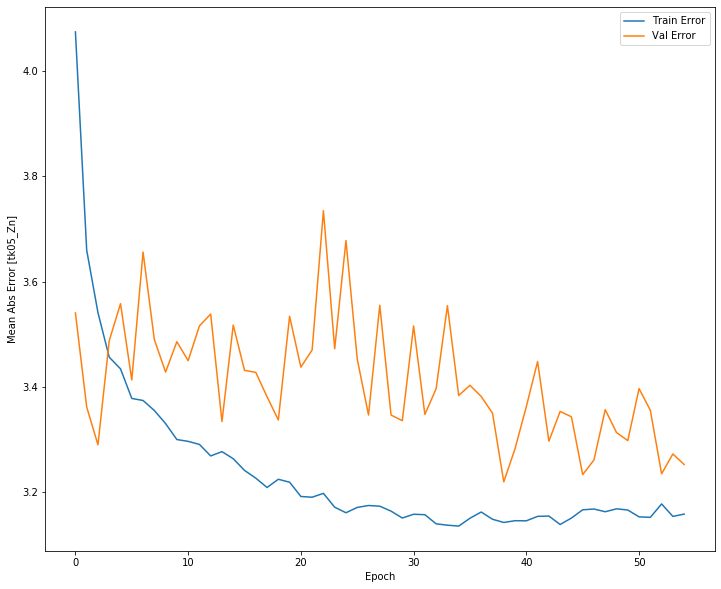

In [91]:
plot_history(history)

In [89]:
model.save(r'C:\Users\v.t.flores\Documents\Zn_tk05_model2_64_320_512_512_512_DropOut_x4') # divide the predicted 106_Zn by 1000 for rescaling correction

#   END of creating a model using linearly interpolated dataset 